 <center> Data Mining and Machine Learning
 <center> Assignment 2
 <center> Soham Biswas (MDS202147)
 <center> Aniket Santra (MDS202106) <br><br>

In [2]:
import os
import random
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist
import time
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

#### Loading data using Pandas

In [3]:
# Enron Emails

d_enron = pd.read_csv("docword.enron.txt", skiprows=3,  delim_whitespace=True, header = None)
d_enron.columns = ['docID','wordID','freq']

# KOS Blog Posts
d_kos = pd.read_csv("docword.kos.txt", skiprows=3,  delim_whitespace=True, header = None)
d_kos.columns = ['docID','wordID','freq']

# NIPS full papers
d_nips = pd.read_csv("docword.nips.txt", skiprows=3,  delim_whitespace=True, header = None)
d_nips.columns = ['docID', 'wordID', 'freq']


In [4]:
# Creating the Sparse Matrices for each document

enron_doc_count = 39861
enron_word_count = 28102

matrix_enron = np.zeros(shape = (enron_doc_count, enron_word_count))

for i, row in d_enron.iterrows():
     matrix_enron[row['docID'] - 1,row['wordID'] - 1] = 1

kos_doc_count = 3430
kos_word_count = 6906
        
matrix_kos = np.zeros(shape = (kos_doc_count ,kos_word_count))

for i, row in d_kos.iterrows():
    matrix_kos[row['docID'] - 1,row['wordID'] - 1] = 1

nips_doc_count = 1500
nips_word_count = 12419

matrix_nips = np.zeros(shape = (nips_doc_count ,nips_word_count))
for i, row in d_nips.iterrows():
    matrix_nips[row['docID'] - 1,row['wordID'] - 1] = 1

In [5]:
# Function to calculate jaccard distance between centroid and data points

def get_j_dist(m1, m2):
    j_dist_cent = []
    for i in range(m1.shape[0]):
        a = m1[i:i + 1,:]
        b = m2
        temp = np.concatenate((a,b),axis = 0)
        j_dist = pairwise_distances(temp, metric='jaccard')[0][1]
        j_dist_cent.append(j_dist)

    return j_dist_cent



In [6]:
# Creating a Jaccard class and defining K-means

class Jaccard_K_Means():
    def __init__(self, mat, num_c, n_init, max_iter, tol, thres, random_state = 22):
        self.mat = mat
        self.num_c = num_c
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.thres = thres
        self.cnt_conv = 0
        self.random_seed = random_state

        for i in range(self.n_init):
            clus_cent = self.initialise_centroids()

            iter = 0
            flag = 0
            iner_list = []
            clus_cent_list = []
            clus_assign_list = []
            while iter <= self.max_iter:
                inertia, new_cent, dist_prv, clus_assign = self.centroid_update(clus_cent)
                iter += 1
                clus_cent = new_cent
                if dist_prv < self.tol:
                    iner_list.append(inertia)
                    clus_cent_list.append(new_cent)
                    clus_assign_list.append(clus_assign)
                    flag = 1
                    self.cnt_conv += 1
                    break

            if flag == 0:
                iner_list.append(inertia)
                clus_cent_list.append(new_cent)
                clus_assign_list.append(clus_assign)
        
        for i in range(self.n_init):
            min_iner = min(iner_list)
            min_iner_ind = iner_list.index(min_iner)
            self.inertia = iner_list[min_iner_ind]
            self.clus_cent = clus_cent_list[min_iner_ind]
            self.clus_assign = clus_assign_list[min_iner_ind]

    def initialise_centroids(self):
        random.seed(self.random_seed)
        cen = random.sample(list(range(self.mat.shape[0])),self.num_c)
        init_cent = np.zeros((len(cen), self.mat.shape[1]))
        for i in range(len(cen)):
            init_cent[i,:] = self.mat[cen[i],:]

        return init_cent

    def centroid_update(self, clus_cent):
        cent_n = clus_cent.shape[0]
        jd_cen = np.zeros((cent_n, self.mat.shape[0]))
        temp_jd = []
        for i in range(cent_n):
            temp_jd = get_j_dist(self.mat, clus_cent[i:i+1,:])
            jd_cen[i,:] = temp_jd

        clus_assign = self.assign_to_clusters(jd_cen)
        inertia = self.get_inertia(clus_assign)
        new_cent = self.get_new_cent(clus_assign, clus_cent)

        dist_prv = 0
        for i in range(cent_n):
            prv_c = clus_cent[i,:]
            new_c = new_cent[i,:]
            dist_prv += np.linalg.norm(prv_c - new_c)**2
        dist_prv = np.sqrt(dist_prv)

        return inertia, new_cent, dist_prv, clus_assign

    def assign_to_clusters(self, jd_cen):
        clus_assign = []
        for i in range(self.mat.shape[0]):
            min_d = min(jd_cen[:,i])
            min_d_index = np.where(jd_cen[:,i] == min_d)[0][0]
            clus_assign.append((i,min_d_index,min_d))

        return clus_assign

    def get_inertia(self, clus_assign):
        inertia = 0
        for i in range(len(clus_assign)):
            inertia += clus_assign[i][2]**2

        return inertia
    
    def get_new_cent(self, clus_assign, clus_cent):
        cent_n = clus_cent.shape[0]
        new_cent = np.zeros(shape=(cent_n, self.mat.shape[1]))
        for i in range(cent_n):
            cnt_clus = 0
            for j in range(len(clus_assign)):
                if clus_assign[j][1] == i:
                    new_cent[i,:] = new_cent[i,:] + self.mat[j,:]
                    cnt_clus += 1
                else:
                    pass
            
            if cnt_clus != 0:
                new_cent[i,:] = new_cent[i,:]*(1/cnt_clus)
            else:
                pass
        
        for i in range(new_cent.shape[0]):
            for j in range(new_cent.shape[1]):
                if new_cent[i,j] < self.thres:
                    new_cent[i,j] = 0
                else:
                    new_cent[i,j] = 1

        return new_cent

In [14]:
%%time
inertia = []
kmean_list = list(range(2,11))
for i in range(2,11):
    
    kmean_model = Jaccard_K_Means(matrix_kos, num_c = i, n_init = 10, max_iter = 300, tol = 10**-2, thres = 0.2, random_state = 25)
    inertia.append(kmean_model.inertia)

Wall time: 34min 35s


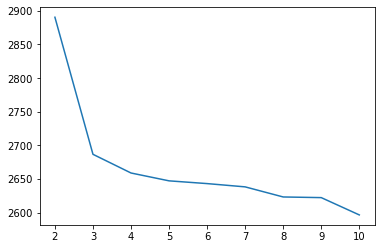

In [33]:
sns.lineplot(x = kmean_list, y = inertia)
plt.show()

In [8]:
%%time
inertia2 = []
kmean2_list = list(range(2,11))
for i in range(2,11):
    kmean2_model = Jaccard_K_Means(matrix_nips, num_c = i, n_init = 10, max_iter = 300, tol = 10**-2, thres = 0.1, random_state = 54)
    inertia2.append(kmean2_model.inertia)

Wall time: 56min 20s


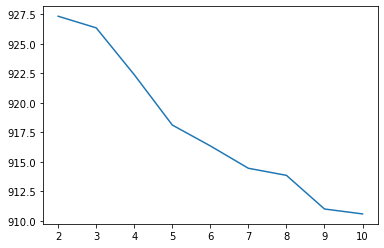

In [9]:
sns.lineplot(x = kmean2_list, y = inertia2)
plt.show()

In [8]:
random.seed(54)
docs = random.sample(range(matrix_enron.shape[0]), k = int(matrix_enron.shape[0]/10))
docs.sort()

matrix_enron_sample = np.zeros((len(docs), matrix_enron.shape[1]))
for i in range(matrix_enron_sample.shape[0]):
    matrix_enron_sample[i,:] = matrix_enron[docs[i],:]

In [9]:
%%time
inertia3 = []
kmean3_list = list(range(2,11))
for i in range(2,11):
    kmean3_model = Jaccard_K_Means(matrix_enron_sample, num_c = i, n_init = 10, max_iter = 300, tol = 10**-2, thres = 0.1, random_state = 54)
    inertia3.append(kmean3_model.inertia)

Wall time: 1h 57min 13s


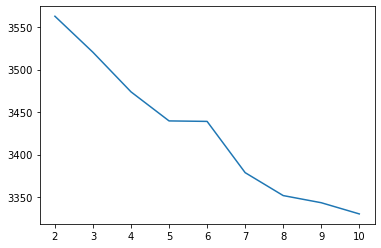

In [10]:
sns.lineplot(x = kmean3_list, y = inertia3)
plt.show()